## Histogram of Gradients (HOG)

The aim of this notebook is to obtain merely HOG images out of the original images. The HOG images are being used as the 4th channel, next to the 3 channels RGB.

### Importing

In [85]:
# Import required packages 
import tensorflow as tf
import image_modeling   # import image_modeling.py file
import tensorflow_hub as hub
import datetime
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
import cv2 as cv2
import pickle

# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [19]:
#!python -m pip install -U scikit-image
#!pip install opencv-python

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
You should consider upgrading via the '/Users/lee/neuefische/Capstone_Project_Turtle_Recall/.venv/bin/python -m pip install --upgrade pip' command.


In [3]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [203]:
# Import variables from image_modelling.py file
HEIGHT = image_modeling.HEIGHT
WIDTH = image_modeling.WIDTH
NCLASSES = image_modeling.NCLASSES
CLASS_NAMES = image_modeling.CLASS_NAMES
BATCH_SIZE = image_modeling.BATCH_SIZE
TRAINING_SIZE = image_modeling.TRAINING_SIZE
TRAINING_STEPS = (TRAINING_SIZE // BATCH_SIZE)

train_data = image_modeling.train_data
test_data = image_modeling.test_data
lines = image_modeling.lines
image_dir = image_modeling.image_dir
length_data = image_modeling.length_data


### Rescaling

To create HOG images out of the original images, they have to be preprocessed: rescaled, but not augmentated, hence augment = False. Here, train_datagen and test_datagen are identical, just the information of rescaling, the images itself are not involved yet.

In [5]:
train_datagen, test_datagen = image_modeling.preprocess(augment=False)

### From dataframe to arrays: train validation split and batches

The function use_image_generator is also used in the notebook "Create Pipeline" and copied into image_modeling.py. Now the data were split into a test and validation dataset. However, much has to be changed here, that's why use_image_generator is defined newly with updated changes: class_mode = None, because the label data are cumbersome, therefore also shuffle = False.

In [208]:
def use_image_generator(train_datagen, test_datagen): 
        train_generator = train_datagen.flow_from_dataframe(dataframe =train_data[0:lines], 
                directory   = image_dir,
                x_col       = "image_id" ,
                target_size = (HEIGHT, WIDTH),
                batch_size  = BATCH_SIZE,
                classes     = CLASS_NAMES,
                class_mode  = None,
                #color_mode  = 'grayscale',                                            
                shuffle     = False)
        
        validation_generator = test_datagen.flow_from_dataframe(dataframe = train_data[lines:], 
                directory    = image_dir,
                x_col        = "image_id",
                target_size  = (HEIGHT, WIDTH),
                batch_size   = BATCH_SIZE,
                classes      = CLASS_NAMES,
                class_mode   = None,
                #color_mode  = 'grayscale',                                                
                shuffle      = False)
        
        return train_generator, validation_generator

For test data:

In [209]:
def use_image_generator_test(test_datagen): 

        test_generator = test_datagen.flow_from_dataframe(dataframe = test_data, 
                directory    = image_dir,
                x_col        = "image_id",
                target_size  = (HEIGHT, WIDTH),
                batch_size   = BATCH_SIZE,
                classes      = CLASS_NAMES,
                class_mode   = None,
                #color_mode  = 'grayscale',                                                
                shuffle      = False)
        
        return test_generator

Now the images were loaded from the dataframe using the use_image_generator function above. They are loaded into batches with the size BATCH_SIZE. The batching process is unnecessary but uncommenting "batch_size" didn't help to avoid batching.

In [ ]:
train_generator, validation_generator = use_image_generator(train_datagen, test_datagen)

Found 1502 validated image filenames.
Found 643 validated image filenames.


/Users/lee/neuefische/Capstone_Project_Turtle_Recall/.venv/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:219: UserWarning: `classes` will be ignored given the class_mode="None"
  warnings.warn('`classes` will be ignored given the class_mode="{}"'


In [210]:
test_generator = use_image_generator_test(test_datagen)

Found 490 validated image filenames.


### Get the labels

In [12]:
train_labels_list = list(train_data.iloc[0:lines]["turtle_id"])
validation_labels_list = list(train_data.iloc[lines:]["turtle_id"])

In [137]:
train_labels_array = np.array(train_labels_list)
validation_labels_array = np.array(validation_labels_list)

In [197]:
#Convert label names from string to numbers by creating a dictionary
unique_label_dict = {}
for n, i in enumerate(CLASS_NAMES):
    unique_label_dict[i] = n

#Using this dictionary to convert train labels and store into a new list    
train_labels_list_float = []    
for i in train_labels_list:
    train_labels_list_float.append(unique_label_dict[i])

#Same with validation labels    
validation_labels_list_float = []    
for i in validation_labels_list:
    validation_labels_list_float.append(unique_label_dict[i])   

#Convert both new lists into arrays (if required)
train_labels_array_float = np.array(train_labels_list_float)
validation_labels_array_float = np.array(validation_labels_list_float)

### Create HOG images

The function get_hog takes the generators generated by the use_image_generator function as input. The outputs are all 1D HOG images and all 2D images, if visualize = True.

In [13]:
def get_hog(images_in_batches, visualize=True):    
    if visualize == True:
        hog_images = []
        bilder = []
        _ = 0
        for i in range(len(images_in_batches)):
            for j in range(BATCH_SIZE):
                fd, bild = hog(images_in_batches[i][j], orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2), channel_axis=-1, visualize=True)
                hog_images.append(fd)
                bilder.append(bild)
                _ += 1
                if _ >= images_in_batches.samples:
                    break
        hog_images = np.array(hog_images)
        bilder = np.array(bilder)
        return hog_images, bilder

    else:
        hog_images = []
        _ = 0
        for i in range(len(images_in_batches)):
            for j in range(BATCH_SIZE):
                fd = hog(images_in_batches[i][j], orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2), channel_axis=-1)
                hog_images.append(fd)
                _ += 1
                if _ >= images_in_batches.samples:
                    break
        hog_images = np.array(hog_images)            
        return hog_images

As a next step, the get_hoc function can be used. Attention, it takes long time to run through:

In [14]:
# 15 Minuten ACHTUNG
train_hog, train_hog_2d = get_hog(train_generator)
validation_hog, validation_hog_2d = get_hog(validation_generator)

In [211]:
# 5 Minuten ACHTUNG
test_hog, test_hog_2d = get_hog(test_generator)

### Add HOG images as a 4th channel

In [15]:
def add_fourth_channel(existing_images_in_batches,new_images_2d):    
    merged_all = []
    _ = 0
    for i in range(len(existing_images_in_batches)):
        for j in range(BATCH_SIZE):
            c1,c2,c3 = cv2.split(existing_images_in_batches[i][j])
            merged_image = cv2.merge((c1,c2,c3,new_images_2d[_]))
            merged_all.append(merged_image)
            _ += 1
            if _ >= existing_images_in_batches.samples:
                break        
    return np.array(merged_all)

In [16]:
alles = add_fourth_channel(train_generator,train_hog_2d)

In [17]:
alles_validation = add_fourth_channel(validation_generator,validation_hog_2d)

In [212]:
alles_test = add_fourth_channel(test_generator,test_hog_2d)

### Save files with pickle

In [201]:
# train data HOG ONLY
pickle_out_HOG_only_train = open("../data/pickles/HOG_only_train.pickle","wb") #wb write binary
pickle.dump(train_hog_2d,pickle_out_HOG_only_train) #dump train to pickle_out
pickle_out_HOG_only_train.close()

# validation data HOG ONLY
pickle_out_HOG_only_validation = open("../data/pickles/HOG_only_validation.pickle","wb") #wb write binary
pickle.dump(validation_hog_2d,pickle_out_HOG_only_validation) #dump train to pickle_out
pickle_out_HOG_only_validation.close()

In [47]:
# train data all four channels
pickle_out_four_channels_train = open("../data/pickles/four_channels_train.pickle","wb") #wb write binary
pickle.dump(alles,pickle_out_four_channels_train) #dump train to pickle_out
pickle_out_four_channels_train.close()

In [48]:
# validation data all four channels
pickle_out_four_channels_validation = open("../data/pickles/four_channels_validation.pickle","wb") #wb write binary
pickle.dump(alles_validation,pickle_out_four_channels_validation) #dump train to pickle_out
pickle_out_four_channels_validation.close()

In [213]:
# test data all four channels
pickle_out_four_channels_test = open("../data/pickles/four_channels_test.pickle","wb") #wb write binary
pickle.dump(alles_test,pickle_out_four_channels_test) #dump train to pickle_out
pickle_out_four_channels_test.close()

### Load files with pickle

In [51]:
# load pickled train data
pickle_in_four_channels_train = open("../data/pickles/four_channels_train.pickle","rb") #read binary
pickle_in_four_channels_train_load =  pickle.load(pickle_in_four_channels_train) #load pickle file

In [52]:
# load pickled validation data
pickle_in_four_channels_validation = open("../data/pickles/four_channels_validation.pickle","rb") #read binary
pickle_in_four_channels_validation_load =  pickle.load(pickle_in_four_channels_validation) #load pickle file

In [214]:
# load pickled test data
pickle_in_four_channels_test = open("../data/pickles/four_channels_test.pickle","rb") #read binary
pickle_in_four_channels_test_load =  pickle.load(pickle_in_four_channels_test) #load pickle file

### InceptionV3

In [367]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Concatenate

In [382]:
# Sequential
model = Sequential()
input_shape = (224, 224, 4)
model.add(Conv2D(3, kernel_size=(7, 7), activation='relu', input_shape=input_shape,padding='same'))



base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224, 3))
base_model.trainable = False


model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(NCLASSES, activation='softmax'))
#lossfunc = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = tf.keras.metrics.TopKCategoricalAccuracy(k=5))

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



In [178]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3427 (Conv2D)        (None, 224, 224, 3)       591       
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_31 (Flatten)        (None, 51200)             0         
                                                                 
 dense_48 (Dense)            (None, 1024)              52429824  
                                                                 
 dropout_24 (Dropout)        (None, 1024)              0         
                                                                 
 dense_49 (Dense)            (None, 101)               103525    
                                                                 
Total params: 74,336,724
Trainable params: 52,533,940

In [383]:
inception =  model.fit(
        x=pickle_in_four_channels_train_load, 
        y=train_labels_array_float,
        validation_data=(pickle_in_four_channels_validation_load,validation_labels_array_float),
        steps_per_epoch=(TRAINING_SIZE // BATCH_SIZE), 
        epochs=10,
        callbacks=[tensorboard_callback])

Epoch 1/10
46/46 [==============================] - 66s 1s/step - loss: 23.2948 - top_k_categorical_accuracy: 0.0752 - val_loss: 4.6156 - val_top_k_categorical_accuracy: 0.0140
Epoch 2/10
46/46 [==============================] - 57s 1s/step - loss: 4.5803 - top_k_categorical_accuracy: 0.0719 - val_loss: 4.6818 - val_top_k_categorical_accuracy: 0.1198
Epoch 3/10
46/46 [==============================] - 57s 1s/step - loss: 4.5246 - top_k_categorical_accuracy: 0.6032 - val_loss: 4.6685 - val_top_k_categorical_accuracy: 0.3468
Epoch 4/10
46/46 [==============================] - 61s 1s/step - loss: 4.4690 - top_k_categorical_accuracy: 0.8282 - val_loss: 4.6919 - val_top_k_categorical_accuracy: 0.7885
Epoch 5/10
46/46 [==============================] - 62s 1s/step - loss: 4.3942 - top_k_categorical_accuracy: 0.7603 - val_loss: 4.6361 - val_top_k_categorical_accuracy: 0.7030
Epoch 6/10
46/46 [==============================] - 60s 1s/step - loss: 4.3012 - top_k_categorical_accuracy: 0.4441 - v

In [389]:
#Get probabilities for all turtle id's
y_preds = model.predict(pickle_in_four_channels_test_load)

Fit the test data:

In [459]:
#Get indices from top 5 predictions
# Corrected: [:,:-6:-1] instead of [:,-5:]
y_preds_sorted = np.argsort(y_preds, axis=1)[:,:-6:-1]

#Save indices of top 5 predictions as dataframe
df = pd.DataFrame(y_preds_sorted)

In [392]:
#Create a DataFrame with top 5 predictions in submission form
list = []
array = []
for line in y_preds_sorted:
    for id in line:
        list.append(CLASS_NAMES[id])
    array.append(list)
    list = []

titles = ['prediction1', 'prediction2','prediction3','prediction4','prediction5']

submission = pd.DataFrame(array, columns= titles)

#Insert image_ids from test_data
test_data = pd.read_csv('../data/test.csv')
submission.insert(loc=0, column='image_id', value=test_data['image_id'])

In [393]:
#Save submission data as CSV
submission.to_csv('../data/submission_hog_test.csv', index = False)

### Auxiliary Labels

Following https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

First, we load the labels, with train-validation split:

In [323]:
train_data_locations = train_data['image_location'][0:lines]
train_data_locations = train_data_locations.apply(lambda x: x.lower())
train_data_locations = train_data_locations.tolist()

validation_data_locations = train_data['image_location'][lines:]
validation_data_locations = validation_data_locations.apply(lambda x: x.lower())
validation_data_locations = validation_data_locations.tolist()

In [357]:
#Convert to integers if necessary
for i in range(len(train_data_locations)):
    if train_data_locations[i] == 'top':
        train_data_locations[i] = int(0)
    elif train_data_locations[i] == 'left':
        train_data_locations[i] = int(1)
    elif train_data_locations[i] == 'right':
        train_data_locations[i] = int(2)
            
for i in range(len(validation_data_locations)):
    if validation_data_locations[i] == 'top':
        validation_data_locations[i] = int(0)
    elif validation_data_locations[i] == 'left':
        validation_data_locations[i] = int(1)
    elif validation_data_locations[i] == 'right':
        validation_data_locations[i] = int(2)

In [ ]:
#Alternative: https://faroit.com/keras-docs/1.2.2/getting-started/sequential-model-guide/ ACHTUNG ALTE VERSION MERGE, jetzt concatenate
left_model = Sequential()
input_shape = (224, 224, 4)
left_model.add(Conv2D(3, kernel_size=(7, 7), activation='relu', input_shape=input_shape,padding='same'))
base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224, 3))
base_model.trainable = False
left_model.add(base_model)
left_model.add(Flatten())
left_model.add(Dense(1024, activation='relu'))
left_model.add(Dropout(0.2))
left_model.add(Dense(NCLASSES, activation='softmax'))



right_model = Sequential()
right_model.add(Dense(1, activation="relu"))
right_model.add(Dense(4, activation="relu"))    
    
    
concat = concatenate([left_model, right_model])    
final_model = Sequential()
final_model.add(concat)
final_model.add(Dense(10, activation='softmax'))    

#danach compile und fit!

In [358]:
def create_mlp(dim, regress=False):
    # define our MLP network
    model2 = Sequential()
    model2.add(Dense(8, input_dim=dim, activation="relu"))
    model2.add(Dense(4, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model2.add(Dense(1, activation="linear"))

    # return our model
    return model2

In [359]:
# Probiere hier Sequential weil es klappte vorher
# Sequential
def create_cnn():
    model = Sequential()
    input_shape = (224, 224, 4)
    model.add(Conv2D(3, kernel_size=(7, 7), activation='relu', input_shape=input_shape,padding='same'))

    base_model = InceptionV3(weights='imagenet', 
                                    include_top=False, 
                                    input_shape=(224, 224, 3))
    base_model.trainable = False

    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(NCLASSES, activation='softmax'))
    #lossfunc = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    return model

In [360]:
# create the MLP and CNN models
mlp = create_mlp(len(train_data_locations), regress=False)
cnn = create_cnn()

# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)


In [361]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = tf.keras.metrics.TopKCategoricalAccuracy(k=5))

In [ ]:
combined = model.fit(
    x = [np.array(train_data_locations),pickle_in_four_channels_train_load],
    y = train_labels_array_float,
    validation_data=([np.array(validation_data_locations), pickle_in_four_channels_validation_load], validation_labels_array_float),
    steps_per_epoch=(TRAINING_SIZE // BATCH_SIZE), 
    epochs=10,
    callbacks=[tensorboard_callback])

In [ ]:
model.summary()

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
model = LinearSVC()
model.fit(train_hog1, train_labels_list)
#%% Evaluate the classifier
print(" Evaluating classifier on test data ...")
predictions = model.predict(validation_hog1)
print(classification_report(validation_labels_list, predictions))

In [283]:
# Hier wie im Tutorial functional mode probiert:
def create_cnn():
    inputShape = (224, 224, 4)
    inputs = Input(shape=inputShape)
    x = Conv2D(3, kernel_size=(7, 7), activation='relu', input_shape=input_shape,padding='same')(inputs)
    base_model = InceptionV3(weights='imagenet', 
                                    include_top=False, 
                                    input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False
    x = base_model(x)    
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(NCLASSES, activation='softmax')(x)

    model = model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = tf.keras.metrics.TopKCategoricalAccuracy(k=5))
    return model

IndentationError: unexpected indent (4231151433.py, line 2)

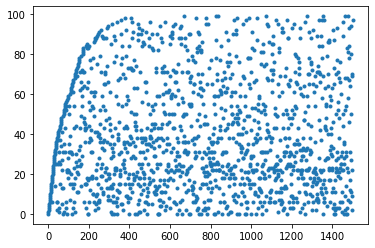

In [381]:
import numpy as np
import matplotlib.pyplot as plt

x = range(len(train_labels_list_float))
y = train_labels_list_float

plt.scatter(x, y,marker=".")
plt.show()

### Visualize HOG images

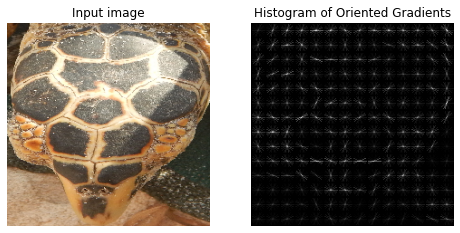

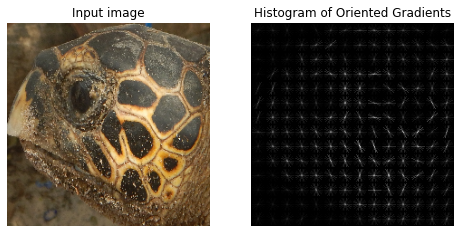

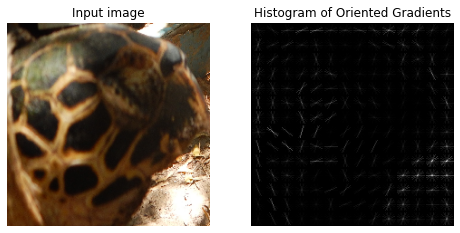

In [409]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.axis('off')
    ax1.imshow(train_generator[0][i], cmap=plt.cm.gray)
    ax1.set_title('Input image')

# Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(train_hog_2d[i], in_range=(0, 10))

    ax2.axis('off')
    ax2.imshow(train_hog_2d[i], cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()